<p style = "text-align: center"><img src = "http://www.ucm.es/logo/ucm.png" alt = "ucm" style = "height: 100px"/>   <img src = "https://www.ucm.es/data/cont/media/www/pag-18458/logo_aocg.jpg" alt = "aocg" style = "height: 100px"/> 


<div align = "center"> 
<font size = 5> Universidad Complutense de Madrid</font>
</div>
    
<div align = "center"> 
<font size = 4> Grupo Computense de Óptica Aplicada </font>
</div>
&nbsp




    
<div align = "center"> 
<font size = 6> Optimization Fourier lens </font>
</div>

Tutorial para optimizar los coeficientes de una lente de Fourier


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (7,3)
rcParams['figure.dpi'] = 200


from diffractio import mm, um, nm
from diffractio import np, plt
from diffractio.utils_math import nearest

from diffractio.scalar_sources_XY import Scalar_source_XY

from diffractio.utils_optics import DOF, beam_width_1D

from py_aocg.angular_lens import Angular_lens, Optimization_lens

## Definición de parámetros de la lente

En primer lugar, definimos los parámetros de la lente a optimizar: diámetro, distancia focal, profundidad de foco, número de coeficientes y longitud de onda.

In [3]:
diameter = 4*mm
wavelength = 632.8 * nm
focal = 125 * mm
delta_f = 12.5 * mm

n_coef = 10
num_periods = 32

In [4]:
x_in = np.linspace(-diameter/2, diameter/2, 512)
y_in = np.linspace(-diameter/2, diameter/2, 512)


x_out = np.linspace(-200 * um, 200 * um, 64)
z_out = np.linspace(focal-delta_f, focal+delta_f, 64)

# Fourier lens

In [5]:
n = np.arange(1,n_coef,1)
coef_lineal,coef_cuadratico,coef_cubico = np.zeros(len(n)),np.zeros(len(n)),np.zeros(len(n))

for i in range(len(n)):
    coef_cuadratico[i] = (8/(np.pi*n[i])**2) 
    if n[i]%2 != 0:
        coef_lineal[i] = (8/(np.pi*n[i])**2) 
        coef_cubico[i] = -6/(np.pi*n[i]**4) + 3*np.pi/(4*n[i]**2)

k1,k2=-0.036,0.175 #sectorized lens seed
an   = (1-k1-k2)*coef_lineal + k1*coef_cuadratico + k2*coef_cubico
coefs=np.array([n, an])

In [6]:
u0 = Scalar_source_XY(x_in, y_in, wavelength)
u0.plane_wave(A=1)

t0 = Angular_lens(x_in, y_in, wavelength)
t0.lens_fourier(r0=(0,0), radius=diameter/2, focal=focal, delta_f=delta_f, num_periods=num_periods, coefs = coefs)

u1=t0*u0
u1.draw('phase')

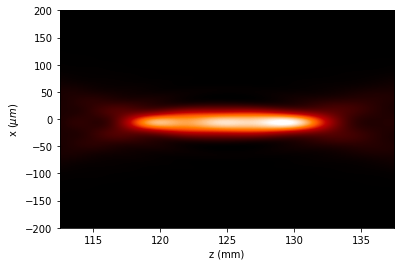

In [7]:
u_czt_xz = u1.CZT(z_out, x_out, yout=np.array([0.,]))
u_czt_xz.draw(z_scale='mm',logarithm=False)

Calculamos la anchura (FWHM) y la intensidad del foco a lo largo de z:

In [8]:
width_czt = u_czt_xz.beam_widths(kind='FWHM1D',has_draw=(False,False))
w_i = width_czt[0]
plt.figure()
plt.plot(z_out/mm,w_i)
plt.ylim(0,80);
plt.xlabel('z (mm)')
plt.ylabel('FWHM ($\mu m$)')

i_0,_,_ = nearest(x_out,0)
I = u_czt_xz.intensity()[i_0,:]
I_perfil=I/I.max()

plt.figure()
plt.plot(z_out/mm,I_perfil) 
plt.xlim(103,147)
plt.ylabel('Intensity')
plt.xlabel('z (mm)')

# Optimización PSO

Inicializamos el objeto de la clase 'Optimization_lens'. Los argumentos de entrada son la lente a optimizar (t0), su distancia focal (focal) y la profunidad de foco de la lente (delta_f).

In [9]:
opt = Optimization_lens(t0,focal=focal,delta_f=delta_f)

## 1º: Optimización de las Ks

In [10]:
num_transitions= 2 #k1 y k2
num_iters= 10 
num_particles = 10 

min_bound = np.array([-0.1,-0.2]) 
max_bound = np.array([0.1,0.2])
bounds = (min_bound, max_bound)

options = {'c1': 0.5, 'c2': 0.6, 'w': 0.9}
#Posiciones iniciales
k0 = np.zeros((num_particles,num_transitions))
k0[:,:] = [-0.036,0.175]

In [11]:
w0 = 25
w1 = 800
delta = 8

args = (u0,z_out,x_out,num_periods,w0,w1,delta,n_coef)
cost,ks = opt.opt_fourier_k(num_particles,options,bounds,k0,args)

2023-12-18 11:57:59,195 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.6, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/10

pyswarms.single.global_best: 100%|██████████|10/10, best_cost=13.7
2023-12-18 12:02:09,738 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 13.673196217078164, best pos: [-0.0421047   0.19818121]


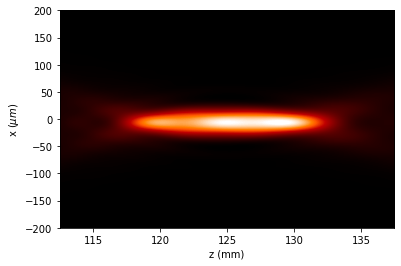

In [12]:
#Utilizando los ks optimizados, definimos los nuevos coeficientes de la lente de Fourier.
an=(1-ks[0]-ks[1])*coef_lineal + ks[0]*coef_cuadratico + ks[1]*coef_cubico
coefs=np.array([n, an])

t0.lens_fourier(r0=(0,0), radius = diameter /2, focal=focal, delta_f=delta_f, num_periods=num_periods, coefs=coefs,binarize=False)

#Propagamos en XZ para observar el resultado de la optimización.
u1 = t0*u0
u_czt_xz = u1.CZT(z_out, x_out, yout=np.array([0.,]))
u_czt_xz.draw(z_scale='mm',logarithm=False)

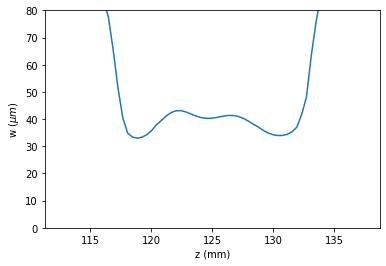

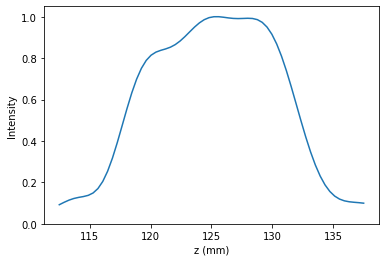

In [13]:
width_czt = u_czt_xz.beam_widths(kind='FWHM1D',has_draw=(False,False))
w_cof = width_czt[0]

z_out_mm = z_out/1000

plt.figure()
plt.plot(z_out_mm,w_cof)
plt.ylabel('w ($\mu m$)')
plt.xlabel('z (mm)')
plt.ylim(0,80)

i_0,_,_ = nearest(x_out,0)
intensidad = u_czt_xz.intensity()[i_0,:]
intensidad_perfil=intensidad/intensidad.max()

plt.figure()
plt.plot(z_out/mm, intensidad_perfil,label='Fourier') 
plt.ylim(0,1.05)
plt.ylabel('Intensity')
plt.xlabel('z (mm)')

##  2º: Optimización de los coeficientes $a_n$

In [14]:
num_particles = 20

#Las posiciones iniciales serán los coeficientes de la optmización anterior.
a0 = np.zeros((num_particles,n_coef-1))
a0[:,:] = an

percentage=0.20
min_bound = np.where(an>0,an - an*percentage,an + an*percentage)
max_bound = np.where(an>0,an + an*percentage,an - an*percentage)
bounds = (min_bound, max_bound)

options = {'c1': 0.5, 'c2': 0.6, 'w': 0.9}

In [15]:
args = (u0,z_out,x_out,num_periods)
cost_2,an_s = opt.opt_fourier_an(num_particles,options,bounds,a0,args)

2023-12-18 12:02:12,681 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 0.5, 'c2': 0.6, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/15

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=7.68
2023-12-18 12:14:29,616 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7.682134521642217, best pos: [ 7.56988839e-01 -7.40381106e-03  1.19123123e-01 -2.01712754e-03
  3.99062980e-02 -8.59567854e-04  2.22420872e-02 -5.56206264e-04
  1.56293465e-02]


In [16]:
coefs = np.array([n,an_s])

t0.lens_fourier(r0=(0,0), radius = diameter /2, focal=focal, delta_f=delta_f, num_periods=num_periods, coefs=coefs,binarize=False)
u1 = t0*u0
u_czt_xz = u1.CZT(z_out, x_out, yout=np.array([0.,]))
u_czt_xz.draw(z_scale='mm',logarithm=False)

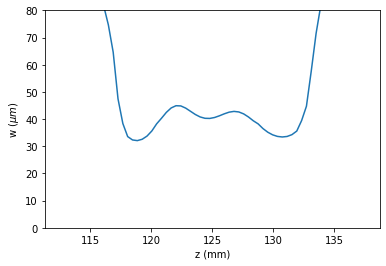

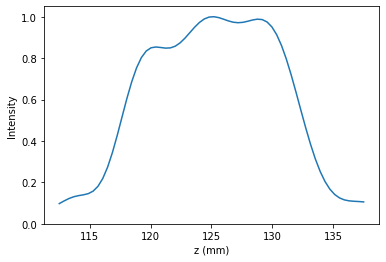

In [17]:
width_czt = u_czt_xz.beam_widths(kind='FWHM1D',has_draw=(False,False))
w_cof = width_czt[0]

z_out_mm = z_out/1000

plt.figure()
plt.plot(z_out_mm,w_cof)
plt.ylabel('w ($\mu m$)')
plt.xlabel('z (mm)')
plt.ylim(0,80)

i_0,_,_ = nearest(x_out,0)
intensidad = u_czt_xz.intensity()[i_0,:]
intensidad_perfil=intensidad/intensidad.max()

plt.figure()
plt.plot(z_out/mm, intensidad_perfil,label='Fourier') 
plt.ylim(0,1.05)
plt.ylabel('Intensity')
plt.xlabel('z (mm)')